In [3]:
from __future__ import print_function

import tensorflow as tf
import pandas as pd
import numpy as np
from sklearn.preprocessing import label_binarize, MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
def neural_net(x):
    layer_1 = tf.add(tf.matmul(x, weights['h1']), biases['b1'])
    layer_1 = tf.nn.relu(layer_1)
    
    out_layer = tf.matmul(layer_1, weights['output']) + biases['output']
    return out_layer

def neural_net_2_layers(x):
    layer_1 = tf.add(tf.matmul(x, weights['h1']), biases['b1'])
    layer_1 = tf.nn.relu(layer_1)
    
    layer_2 = tf.add(tf.matmul(layer_1, weights['h2']), biases['b2'])
    layer_2 = tf.nn.relu(layer_2)
    
    out_layer = tf.matmul(layer_2, weights['output']) + biases['output']
    return out_layer

In [5]:
def split_data(file):
    filename = [file]
    record_defaults = [tf.float32] * 75   # Eight required float columns
    dataset = tf.contrib.data.CsvDataset(filename, record_defaults)
    return dataset

In [54]:
train_df = pd.read_csv("Data/formated.csv")
test_df = pd.read_csv("Data/formatedTesting.csv")

train_df.columns = [col.strip() for col in train_df.columns]
test_df.columns = [col.strip() for col in test_df.columns]

input_nodes = 72 # maybe 75 for a bias
output_nodes = 3
learning_rate = 0.01

# Delete duplicate columns
del train_df["e1"]
del train_df["e1.1"]
del test_df["e1"]
del test_df["e1.1"]

# Uncomment this block to try out different set of features
feature_subset = ["assist count", "assist count 2", "shots made", "e6", "is goal 2", "s1.1",
                            "e6.1", "is goal", "e4", "e2", "shots made 2", "s2.1", "e2.1", "target Feature"]
train_df = train_df.loc[:, feature_subset]
test_df = test_df.loc[:, feature_subset]
input_nodes = 13 # maybe 75 for a bias

X = tf.placeholder("float", [None, input_nodes])
Y = tf.placeholder("float", [None, output_nodes])

# Split the dataframe into features and labels arrays
train_features_array = train_df.iloc[:, :-1].values
train_labels_array = train_df.loc[:, "target Feature"].values
train_labels_binarized = label_binarize(train_labels_array, classes=[0,1,2])
print(train_labels_binarized)
test_features_array = test_df.iloc[:, :-1].values
test_labels_array = test_df.loc[:, "target Feature"].values
test_labels_binarized = label_binarize(test_labels_array, classes=[0,1,2])

normalizer = MinMaxScaler((0,1))
normalizer.fit(train_features_array)

train_features_normalized = normalizer.transform(train_features_array)
test_features_normalized = normalizer.transform(test_features_array)

train_features_normalized, vald_features_normalized, train_labels_binarized, vald_labels_binarized = train_test_split(train_features_normalized, train_labels_binarized, test_size=0.10, random_state=20)

[[0 1 0]
 [0 1 0]
 [0 1 0]
 ...
 [0 1 0]
 [1 0 0]
 [0 1 0]]


/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [48]:
# hLayers = 2
# hLayerOne = 36 # half of input nodes
# hLayerTwo = 36 # for sigmoid function


# #epochs = 1 # number of times to iterate over data
# batches = 3
# train_batch = int(len(train_df)/batches)
# test_batch = int(len(test_df)/batches)
# # keep_prob = tf.placeholder("float")
# # print(keep_prob)

# print(X)
# print(Y)

## Tuning network with 1 hidden layer

In [46]:
total_batch = train_features_array.shape[0]
max_validation_accuracy = 0
optimal_weights = {}
optimal_n_units = 0

n_layer_one_units = [i for i in range(2, 11, 2)]
accuracies = {}

for n_unit_1 in n_layer_one_units:
    print("Trying {} units in layer 1".format(n_unit_1))

    weights = {
        'h1': tf.Variable(tf.random_normal([input_nodes, n_unit_1]), name="h1"),
        'output': tf.Variable(tf.random_normal([n_unit_1, output_nodes]), name="output_weights")
    }

    biases = {
        'b1': tf.Variable(tf.random_normal([n_unit_1]), name="b1"),
        'output': tf.Variable(tf.random_normal([output_nodes]), name="output_bias")
    }

    # Construct model
    logits = neural_net(X)

    # Finding the cost of the algorithm
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=Y))

    # Finding optimization of the algorithm
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())

        for i in range(1, 1001):
            avg_cost = 0.0
            _, c = sess.run([optimizer, cost], 
                            feed_dict={
                                X: train_features_normalized, 
                                Y: train_labels_binarized, 
                            })
            avg_cost += c / total_batch
#             if i % 100 == 0:
#                 print("Epoch:", '%04d' % (i), "cost=", "{:.9f}".format(avg_cost))

#         print("Optimization Finished!")            

#         print()

        train_pred = tf.nn.softmax(logits)
        correct_train_prediction = tf.equal(tf.argmax(train_pred, 1), tf.argmax(Y, 1))
        train_accuracy = tf.reduce_mean(tf.cast(correct_train_prediction, "float"))
        print("Training accuracy: ", train_accuracy.eval({X: train_features_normalized, Y: train_labels_binarized}))

        valid_pred = tf.nn.softmax(logits)
        correct_valid_prediction = tf.equal(tf.argmax(valid_pred, 1), tf.argmax(Y, 1))
        valid_accuracy = tf.reduce_mean(tf.cast(correct_valid_prediction, "float"))
        valid_accuracy_value = valid_accuracy.eval({X: vald_features_normalized, Y: vald_labels_binarized})
        accuracies[n_unit_1] = valid_accuracy_value
        print("Validation accuracy: ", valid_accuracy_value)
        
        if max_validation_accuracy < valid_accuracy_value:
            max_validation_accuracy = valid_accuracy_value
            optimal_n_units = n_unit_1
            optimal_weights["h1"] = weights["h1"].eval()
            optimal_weights["output_weights"] = weights["output"].eval()
            optimal_weights["b1"] = biases["b1"].eval()
            optimal_weights["output_bias"] = biases["output"].eval()

    print("------------------------------")

print("Optimal number of units in first hidden layer: {}".format(optimal_n_units))
print("Maximum validation accuracy: {}".format(max_validation_accuracy))

Trying 2 units in layer 1
Training accuracy:  0.75775385
Validation accuracy:  0.7312775
------------------------------
Trying 4 units in layer 1
Training accuracy:  0.75987595
Validation accuracy:  0.7312775
------------------------------
Trying 6 units in layer 1
Training accuracy:  0.76379365
Validation accuracy:  0.72246695
------------------------------
Trying 8 units in layer 1
Training accuracy:  0.75857
Validation accuracy:  0.7283407
------------------------------
Trying 10 units in layer 1
Training accuracy:  0.7605289
Validation accuracy:  0.72540385
------------------------------
Optimal number of units in first hidden layer: 2
Maximum validation accuracy: 0.7312775254249573


In [47]:
tmp_df = pd.DataFrame({"n_units": n_layer_one_units, "accuracy": list(accuracies.values())})

Text(0.5, 1.0, 'Accuracy on validation set')

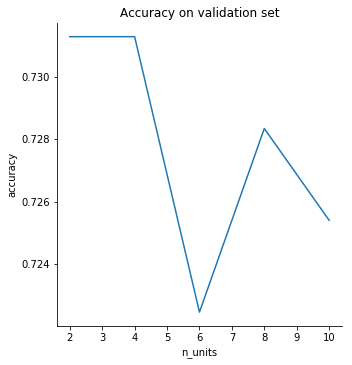

In [48]:
sns.relplot(x="n_units", y="accuracy", data=tmp_df, kind="line")
plt.title("Accuracy on validation set")

In [49]:
train_df = train_df.loc[:, feature_subset]
test_df = test_df.loc[:, feature_subset]
input_nodes = 13 # maybe 75 for a bias

train_features_array = train_df.iloc[:, :-1].values
train_labels_array = train_df.loc[:, "target Feature"].values
train_labels_binarized = label_binarize(train_labels_array, classes=[0,1,2])
test_features_array = test_df.iloc[:, :-1].values
test_labels_array = test_df.loc[:, "target Feature"].values
test_labels_binarized = label_binarize(test_labels_array, classes=[0,1,2])

normalizer = MinMaxScaler((0,1))
normalizer.fit(train_features_array)

train_features_normalized = normalizer.transform(train_features_array)

weights = {
        'h1': tf.Variable(tf.random_normal([input_nodes, optimal_n_units]), name="h1"),
        'output': tf.Variable(tf.random_normal([optimal_n_units, output_nodes]), name="output_weights")
    }

biases = {
    'b1': tf.Variable(tf.random_normal([optimal_n_units]), name="b1"),
    'output': tf.Variable(tf.random_normal([output_nodes]), name="output_bias")
}

# Construct model
logits = neural_net(X)

# Finding the cost of the algorithm
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=Y))

# Finding optimization of the algorithm
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())

    for i in range(1, 1001):
        avg_cost = 0.0
        _, c = sess.run([optimizer, cost], 
                        feed_dict={
                            X: train_features_normalized, 
                            Y: train_labels_binarized, 
                        })
        avg_cost += c / total_batch
#             if i % 100 == 0:
#                 print("Epoch:", '%04d' % (i), "cost=", "{:.9f}".format(avg_cost))

#         print("Optimization Finished!")            

#         print()

    train_pred = tf.nn.softmax(logits)
    correct_train_prediction = tf.equal(tf.argmax(train_pred, 1), tf.argmax(Y, 1))
    train_accuracy = tf.reduce_mean(tf.cast(correct_train_prediction, "float"))
    print("Training accuracy: ", train_accuracy.eval({X: train_features_normalized, Y: train_labels_binarized}))

    test_pred = tf.nn.softmax(logits)
    correct_test_prediction = tf.equal(tf.argmax(test_pred, 1), tf.argmax(Y, 1))
    test_accuracy = tf.reduce_mean(tf.cast(correct_test_prediction, "float"))
    test_accuracy_value = test_accuracy.eval({X: test_features_normalized, Y: test_labels_binarized})
    print("Test accuracy: ", test_accuracy_value)

/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


Training accuracy:  0.7570148
Test accuracy:  0.74459636


## Tuning network with 2 hidden layers

In [51]:
total_batch = train_features_array.shape[0]
max_validation_accuracy = 0
optimal_weights = {}
optimal_n_units_1 = 0
optimal_n_units_2 = 0

n_layer_one_units = [i for i in range(2, 7, 2)]
n_layer_two_units = [i for i in range(2, 7)]
accuracies = {}

for n_unit_1 in n_layer_one_units:
    for n_unit_2 in n_layer_two_units:
        print("Trying {} units in layer 1 and {} units in layer 2".format(n_unit_1, n_unit_2))

        weights = {
            'h1': tf.Variable(tf.random_normal([input_nodes, n_unit_1]), name="h1"),
            'h2': tf.Variable(tf.random_normal([n_unit_1, n_unit_2])),
            'output': tf.Variable(tf.random_normal([n_unit_2, output_nodes]), name="output_weights")
        }

        biases = {
            'b1': tf.Variable(tf.random_normal([n_unit_1]), name="b1"),
            'b2': tf.Variable(tf.random_normal([n_unit_2])),
            'output': tf.Variable(tf.random_normal([output_nodes]), name="output_bias")
        }

        # Construct model
        logits = neural_net_2_layers(X)

        # Finding the cost of the algorithm
        cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=Y))

        # Finding optimization of the algorithm
        optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

        with tf.Session() as sess:
            sess.run(tf.global_variables_initializer())

            for i in range(1, 1001):
                avg_cost = 0.0
                _, c = sess.run([optimizer, cost], 
                                feed_dict={
                                    X: train_features_normalized, 
                                    Y: train_labels_binarized, 
                                })
                avg_cost += c / total_batch
    #             if i % 100 == 0:
    #                 print("Epoch:", '%04d' % (i), "cost=", "{:.9f}".format(avg_cost))

    #         print("Optimization Finished!")            

    #         print()

            train_pred = tf.nn.softmax(logits)
            correct_train_prediction = tf.equal(tf.argmax(train_pred, 1), tf.argmax(Y, 1))
            train_accuracy = tf.reduce_mean(tf.cast(correct_train_prediction, "float"))
            print("Training accuracy: ", train_accuracy.eval({X: train_features_normalized, Y: train_labels_binarized}))

            valid_pred = tf.nn.softmax(logits)
            correct_valid_prediction = tf.equal(tf.argmax(valid_pred, 1), tf.argmax(Y, 1))
            valid_accuracy = tf.reduce_mean(tf.cast(correct_valid_prediction, "float"))
            valid_accuracy_value = valid_accuracy.eval({X: vald_features_normalized, Y: vald_labels_binarized})
            accuracies[(n_unit_1, n_unit_2)] = valid_accuracy_value
            print("Validation accuracy: ", valid_accuracy_value)

            if max_validation_accuracy < valid_accuracy_value:
                max_validation_accuracy = valid_accuracy_value
                optimal_n_units_1 = n_unit_1
                optimal_n_units_2 = n_unit_2
                optimal_weights["h1"] = weights["h1"].eval()
                optimal_weights["h2"] = weights["h2"].eval()
                optimal_weights["output_weights"] = weights["output"].eval()
                optimal_weights["b1"] = biases["b1"].eval()
                optimal_weights["b2"] = biases["b1"].eval()
                optimal_weights["output_bias"] = biases["output"].eval()

        print("------------------------------")

print("Optimal number of units in first hidden layer: {}".format(optimal_n_units_1))
print("Optimal number of units in second hidden layer: {}".format(optimal_n_units_2))
print("Maximum validation accuracy: {}".format(max_validation_accuracy))

Trying 2 units in layer 1 and 2 units in layer 2
Training accuracy:  0.7588965
Validation accuracy:  0.72540385
------------------------------
Trying 2 units in layer 1 and 3 units in layer 2
Training accuracy:  0.75954944
Validation accuracy:  0.7283407
------------------------------
Trying 2 units in layer 1 and 4 units in layer 2
Training accuracy:  0.75987595
Validation accuracy:  0.72540385
------------------------------
Trying 2 units in layer 1 and 5 units in layer 2
Training accuracy:  0.7590597
Validation accuracy:  0.7312775
------------------------------
Trying 2 units in layer 1 and 6 units in layer 2
Training accuracy:  0.7597127
Validation accuracy:  0.7283407
------------------------------
Trying 4 units in layer 1 and 2 units in layer 2
Training accuracy:  0.76216125
Validation accuracy:  0.7312775
------------------------------
Trying 4 units in layer 1 and 3 units in layer 2
Training accuracy:  0.759223
Validation accuracy:  0.7298091
------------------------------
Tr

In [55]:
train_df = train_df.loc[:, feature_subset]
test_df = test_df.loc[:, feature_subset]
input_nodes = 13 # maybe 75 for a bias

train_features_array = train_df.iloc[:, :-1].values
train_labels_array = train_df.loc[:, "target Feature"].values
train_labels_binarized = label_binarize(train_labels_array, classes=[0,1,2])

normalizer = MinMaxScaler((0,1))
normalizer.fit(train_features_array)

train_features_normalized = normalizer.transform(train_features_array)
weights = {
    'h1': tf.Variable(tf.random_normal([input_nodes, optimal_n_units_1]), name="h1"),
    'h2': tf.Variable(tf.random_normal([optimal_n_units_1, optimal_n_units_2])),
    'output': tf.Variable(tf.random_normal([optimal_n_units_2, output_nodes]), name="output_weights")
}

biases = {
    'b1': tf.Variable(tf.random_normal([optimal_n_units_1]), name="b1"),
    'b2': tf.Variable(tf.random_normal([optimal_n_units_2])),
    'output': tf.Variable(tf.random_normal([output_nodes]), name="output_bias")
}

# Construct model
logits = neural_net_2_layers(X)

# Finding the cost of the algorithm
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=Y))

# Finding optimization of the algorithm
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())

    for i in range(1, 1001):
        avg_cost = 0.0
        _, c = sess.run([optimizer, cost], 
                        feed_dict={
                            X: train_features_normalized, 
                            Y: train_labels_binarized, 
                        })
        avg_cost += c / total_batch
#             if i % 100 == 0:
#                 print("Epoch:", '%04d' % (i), "cost=", "{:.9f}".format(avg_cost))

#         print("Optimization Finished!")            

#         print()

    train_pred = tf.nn.softmax(logits)
    correct_train_prediction = tf.equal(tf.argmax(train_pred, 1), tf.argmax(Y, 1))
    train_accuracy = tf.reduce_mean(tf.cast(correct_train_prediction, "float"))
    print("Training accuracy: ", train_accuracy.eval({X: train_features_normalized, Y: train_labels_binarized}))
          
    test_pred = tf.nn.softmax(logits)
    correct_test_prediction = tf.equal(tf.argmax(test_pred, 1), tf.argmax(Y, 1))
    test_accuracy = tf.reduce_mean(tf.cast(correct_test_prediction, "float"))
    print("Test accuracy: ", test_accuracy.eval({X: test_features_normalized, Y: test_labels_binarized}))

/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


Training accuracy:  0.7561334
Test accuracy:  0.74459636
